In [1]:
import os
from tqdm import tqdm
import math

In [2]:
data_dir = "./data"
downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

In [3]:
# Download ADE20K scene parsing dataset
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip -O {downloads_dir}/scene_parsing.zip
# !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip -O {downloads_dir}/scene_parsing_test.zip

!unzip -q -o {downloads_dir}'/scene_parsing.zip' -d {datasets_dir}
# !unzip -q -o {downloads_dir}'/scene_parsing_test.zip' -d {datasets_dir}
!rm -rf {downloads_dir}

--2022-05-08 19:52:59--  http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 967382037 (923M) [application/zip]
Saving to: ‘./data/downloads/scene_parsing.zip’

./data/downloads/sc 100%[===================>] 922.57M  34.5MB/s    in 27s     

2022-05-08 19:53:27 (33.8 MB/s) - ‘./data/downloads/scene_parsing.zip’ saved [967382037/967382037]



In [4]:
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00001701.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00001701.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00003020.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00003020.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00008455.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00008455.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00013508.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00013508.png"

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars

from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


## Data Loader

In [ ]:
this_seg = PIL.Image.open("/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00000001.png")
this_seg = transforms.Resize([512,512])(this_seg)

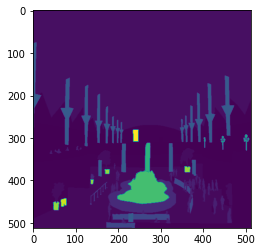

In [ ]:
np_img = np.asarray(this_seg).astype(np.int64)
plt.imshow(np_img)

In [ ]:
laplacian_kernel = PIL.ImageFilter.Kernel(size=(3, 3), kernel=(0, 1, 0, 1, -4, 1, 0, 1, 0), scale=1, offset=0)

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import glob

def get_edge_annotation(img):

    edge_kernel = PIL.ImageFilter.Kernel(size=(3, 3), kernel=(-1, -1, -1, -1,  8, -1, -1, -1, -1), scale=1, offset=0)
    np_img = np.asarray(img).astype(np.int64)
    edge = np.zeros(np_img.shape)

    for i in range(151):

        this_mask = np.where(np_img == i, i, 0)
        this_filter = img.filter(edge_kernel)
        this_edge = np.multiply(np.asarray(this_filter).astype(np.int64), this_mask)
        this_edge = np.where(this_edge > 0, i, 0)
        edge += this_edge

    return edge

class DataLoaderSegmentationEdge(data.Dataset):
    def __init__(self, folder_path, split="training"):
        super(DataLoaderSegmentationEdge, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'images', split, '*.jpg')))
        self.mask_files =  sorted(glob.glob(os.path.join(folder_path,'annotations', split, '*.png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = PIL.Image.open(img_path)
        mask = PIL.Image.open(mask_path)

        image = np.asarray(transforms.Resize([512,512])(image))
        image = transforms.ToTensor()(np.array(image))
        mask = transforms.Resize([512,512])(mask)
        edge_mask = get_edge_annotation(mask)
        mask = np.asarray(mask).astype(np.int64)
        # edge_mask = np.asarray(edge_mask).astype(np.int64)
        # edge_mask = np.where(edge_mask > 0, 1, 0)
        # edge_mask = PIL.Image.fromarray(np.uint8(edge_mask)).convert('RGB')
        # edge_mask = np.asarray(transforms.Resize([512,512])(edge_mask))
        # edge_mask = edge_mask.astype(np.int64)
        # if (image.shape[0] == 1):
        #   image = np.stack((image,)*3, axis=0)
        
        return image, torch.from_numpy(mask), torch.from_numpy(edge_mask)#torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files) // 4

In [ ]:
folder_path = "/content/data/datasets/ADEChallengeData2016/"
train_data = DataLoaderSegmentationEdge(folder_path)
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers = 2)
print("Check how many steps in one training epoch: ", len(train_data_loader))

Check how many steps in one training epoch:  13


In [ ]:
validation_data = DataLoaderSegmentationEdge(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=True, num_workers = 2)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  2


In [ ]:
img, seg, edge = next(iter(train_data_loader))

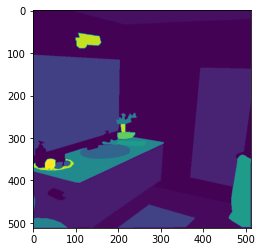

In [ ]:
plt.imshow(seg[7,:,:])

In [ ]:
seg[0,400,180:240]

tensor([66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,
         0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11])

In [ ]:
edge[0,400,180:240]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 66.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
this_mask = np.where(seg == 38, 38, 0)
this_mask[0,400,180:240]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38])

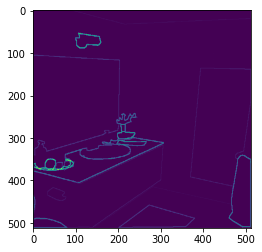

In [ ]:
plt.imshow(edge[7,:,:])

## Visualize the First Batch with Edge

In [7]:
def visualize_first_n(batch_img, batch_seg, n):
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(batch_img[i,:,:,:].permute((1,2,0)))
    ax.axis('off')
    ax.set_title('image {}'.format(i+1))
    i += 1

  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    if ax is None:
        break
    seg_mask = np.zeros((512,512,3))
    for k in range(512):
      for j  in range(512):
        seg_mask[k,j,:] = PALETTE[batch_seg[i,k,j].item()]/255.0
    ax.imshow(seg_mask)
    ax.axis('off')
    ax.set_title('annotation {}'.format(i+1))
    i += 1

PALETTE = torch.tensor([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20], [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0], [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255], [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0], [92, 0, 255], [30, 180, 120]
])


def vis_with_edge(batch_img, batch_seg, batch_edge, n):
  visualize_first_n(batch_img, batch_seg, n)
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    if ax is None:
        break
    #this_edge = np.where(edge[i,:,:] == 0, 255, edge[i,:,:])
    ax.imshow(edge[i,:,:])
    ax.axis('off')
    ax.set_title('edge {}'.format(i+1))
    i += 1


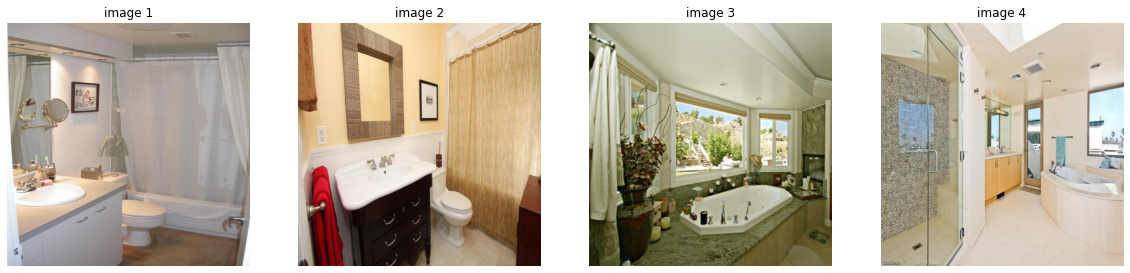

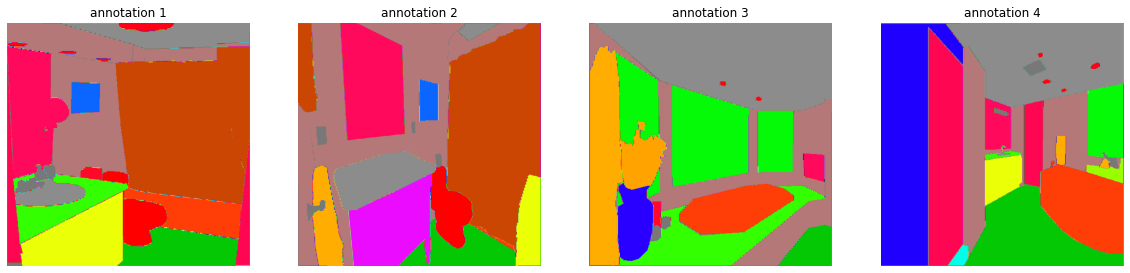

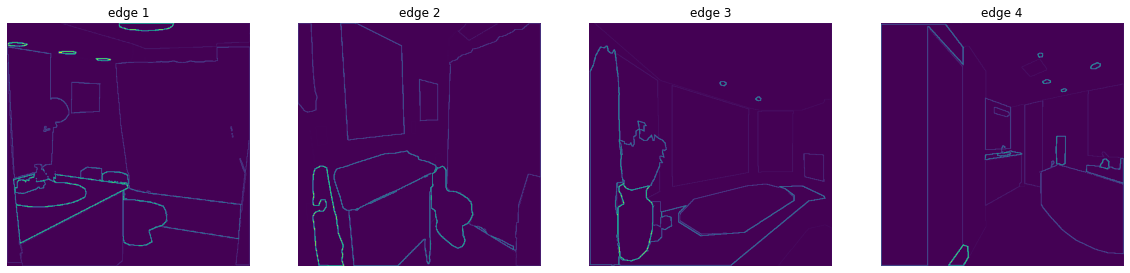

In [ ]:
vis_with_edge(img, seg, edge, 4)

## Define our Loss Function
weighted average of segmentation loss and edge classification loss.

In [ ]:
from scipy import ndimage

t = ndimage.distance_transform_edt(seg_out.detach().numpy())
t[t > 1] = 0
print(t.sum())

In [ ]:
seg_out, edge_out = net(img.to(device))

In [ ]:
edge_out.shape

torch.Size([8, 151, 512, 512])

In [ ]:
edge_loss = torch.nn.CrossEntropyLoss()
l = edge_loss(edge_out, edge.long().to(device))
l

tensor(5.0795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [8]:
class SegLossEdgeAttention(nn.Module):
    def __init__(self, num_classes, mode='train', edge_weight=0.3, seg_weight=0.7, edge_class_weight=0.001):
        super(SegLossEdgeAttention, self).__init__()
        w = np.ones(shape=151)
        w[0] = edge_class_weight
        self.class_weight = torch.tensor(w, dtype=torch.float)
        self.num_classes = num_classes
        self.seg_loss = torch.nn.CrossEntropyLoss() # softmax with crossentropy
        self.edge_loss = torch.nn.CrossEntropyLoss(weight=self.class_weight) #torch.nn.BCEWithLogitsLoss() # sigmoid with crossentropy

        self.edge_weight = edge_weight
        self.seg_weight = seg_weight

    def forward(self, inputs, targets):
        seg_in, edge_in = inputs
        seg_mask, edge_mask = targets
        losses = {}

        losses['seg_loss'] = self.seg_weight * self.seg_loss(seg_in, seg_mask.long())
        losses['edge_loss'] = self.edge_weight * self.edge_loss(edge_in, edge_mask.long())

        return losses

## Training

In [9]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [11]:
def train(train_loader, net, criterion, optimizer, curr_epoch):
    """
    Runs the training loop per epoch
    train_loader: Data loader for train
    net: the network
    optimizer: optimizer
    curr_epoch: current epoch
    writer: tensorboard writer
    return:
    """
    net.train()
    #net = net.to(device)

    train_main_loss = AverageMeter()
    curr_iter = 0#curr_epoch * len(train_loader)

    batches = tqdm(train_loader, total=len(train_loader))
    batches.set_description('Training: [epoch {}], [iter {} / {}], [seg loss {:0.6f}],[edge_loss {:0.6f}],[lr {:0.6f}]')

    for inputs, mask, edge in batches:

        inputs = inputs.type(torch.cuda.FloatTensor).to(device)
        mask = mask.type(torch.cuda.FloatTensor).to(device)
        #edge = torch.unsqueeze(edge, 1)
        edge = edge.type(torch.cuda.FloatTensor).to(device)

        optimizer.zero_grad()

        seg_out, mask_out = net(inputs)
        loss = criterion((seg_out, mask_out), (mask, edge))
        main_loss = loss['seg_loss']
        main_loss += loss['edge_loss']

        main_loss.backward()
        optimizer.step()
        train_main_loss.update(main_loss.item())
        

        batches.set_description('Train: [epoch {}], [{} / {}], [seg loss {:0.2f}],[edge_loss {:0.2f}],[lr {:0.4f}]'.format(
              epoch, curr_iter + 1, len(train_loader), loss['seg_loss'],loss['edge_loss'],optimizer.param_groups[-1]['lr']))
        
        if curr_iter % 100 == 0:
          print('Train: [epoch {}], [{} / {}], [seg loss {:0.2f}],[edge_loss {:0.2f}],[lr {:0.4f}]'.format(
              epoch, curr_iter + 1, len(train_loader), loss['seg_loss'],loss['edge_loss'],optimizer.param_groups[-1]['lr']))
          
        curr_iter += 1

    return  train_main_loss.avg

In [12]:
def validate(val_loader, net, criterion, curr_epoch):
    """
    Runs the validation loop after each training epoch
    val_loader: Data loader for validation
    net: thet network
    criterion: loss fn
    optimizer: optimizer
    curr_epoch: current epoch
    writer: tensorboard writer
    return: val_avg for step function if required
    """

    net.eval()
    val_loss = AverageMeter()
    iou_acc = 0
    curr_iter = curr_epoch * len(val_loader)

    batches = tqdm(val_loader, total=len(val_loader))
    batches.set_description('Training: [epoch {}], [iter {} / {}], [seg loss {:0.6f}],[edge_loss {:0.6f}],[lr {:0.6f}]')

    for inputs, mask, edge in batches:

        inputs = inputs.type(torch.cuda.FloatTensor).to(device)
        mask = mask.type(torch.cuda.FloatTensor).to(device)
        #edge = torch.unsqueeze(edge, 1)
        edge = edge.type(torch.cuda.FloatTensor).to(device)

        with torch.no_grad():
            seg_out, mask_out = net(inputs)

        loss = criterion((seg_out, mask_out), (mask, edge))
        main_loss = loss['seg_loss']
        main_loss += loss['edge_loss']

        val_loss.update(main_loss.item())
        curr_iter += 1
        

        batches.set_description('Val: [epoch {}], [{} / {}], [seg loss {:0.2f}],[edge_loss {:0.2f}]'.format(
              epoch, curr_iter + 1, len(val_loader), loss['seg_loss'],loss['edge_loss']))
          

    return val_loss.avg # retuen the value of loss

In [13]:
folder_path = "/content/data/datasets/ADEChallengeData2016/"

In [ ]:
execfile("/content/Unet_with_multi_edge_e2_d1.py")
net = UnetResNetEdge(encoder_name="resnet34", edge_encoder_name = "resnet18",
                           num_classes=151, 
                           input_channels=3, 
                           num_filters=32, 
                           Dropout=0.3)
net.to(device)

In [15]:
batch_size = 4
num_classes = 151
edge_weight = 0.5
seg_weight = 1
learning_rate = 0.0007
load_weight = False
start_epoch = 23
max_epoch = 30
weight_decay = 5e-4
momentum = 0.9
model_name = "unet_edge_model_e2_d1_multi_edge_weight"
save_dir = f"/content/drive/MyDrive/MIT/6.869/Project/model/{model_name}"

if not os.path.exists(save_dir):
  os.makedirs(save_dir)
  print("Directory '%s' created" %model_name)

In [16]:
weight_file = f"{save_dir}/unet_edge_model_e28.pth"

net.load_state_dict(torch.load(weight_file))
net.to(device)
print(f"Load weight from {weight_file}")

Load weight from /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e28.pth


In [38]:
train_data = DataLoaderSegmentationEdge(folder_path)
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16)
print("Check how many steps in one training epoch: ", len(train_data_loader))
validation_data = DataLoaderSegmentationEdge(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=16)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  2526
Check how many steps in one training epoch:  250


In [19]:
criterion = SegLossEdgeAttention(num_classes, mode='train', edge_weight=edge_weight, seg_weight=seg_weight).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lambda1 = lambda epoch: math.pow(1 - epoch / max_epoch, 0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

train_loss = []
val_loss = []

best_loss = 1000

In [21]:
for epoch in range(start_epoch, max_epoch):
    
    train_l = train(train_data_loader, net, criterion, optimizer, epoch)
    print('Train: [epoch {}], [Avg loss {:0.2f}]'.format(epoch, train_l))
    val_l = validate(validation_data_loader, net, criterion, epoch)
    print('Val: [epoch {}], [Avg loss {:0.2f}]'.format(epoch, val_l))
    train_loss.append(train_l)
    val_loss.append(val_l)

    if val_l < best_loss:
      model_name = f"{save_dir}/unet_edge_model_e{epoch}.pth"
      torch.save(net.state_dict(), model_name)
      print(f"Save {model_name}!")
      best_loss = val_l

    scheduler.step()

    with open(f"{save_dir}/loss_record.txt", "w") as f:
      f.write("train_loss:" + "\n")
      for s in train_loss:
        f.write(str(s) +" ")
      
      # f.write("train_seg_loss:" + "\n")
      # for s in train_seg_loss:
      #   f.write(str(s) +" ")
      
      # f.write("train_edge_loss:" + "\n")
      # for s in train_edge_loss:
      #   f.write(str(s) +" ")
      
      f.write("val_loss:" + "\n")
      for s in val_loss:
        f.write(str(s) +" ")

  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 23], [1 / 2526], [seg loss 4.28],[edge_loss 1.90],[lr 0.0007]
Train: [epoch 23], [101 / 2526], [seg loss 2.68],[edge_loss 1.47],[lr 0.0007]
Train: [epoch 23], [201 / 2526], [seg loss 3.02],[edge_loss 1.54],[lr 0.0007]
Train: [epoch 23], [301 / 2526], [seg loss 3.92],[edge_loss 1.82],[lr 0.0007]
Train: [epoch 23], [401 / 2526], [seg loss 3.07],[edge_loss 1.50],[lr 0.0007]
Train: [epoch 23], [501 / 2526], [seg loss 3.91],[edge_loss 1.80],[lr 0.0007]
Train: [epoch 23], [601 / 2526], [seg loss 2.65],[edge_loss 1.43],[lr 0.0007]
Train: [epoch 23], [701 / 2526], [seg loss 2.29],[edge_loss 1.17],[lr 0.0007]
Train: [epoch 23], [801 / 2526], [seg loss 4.88],[edge_loss 2.08],[lr 0.0007]
Train: [epoch 23], [901 / 2526], [seg loss 3.10],[edge_loss 1.48],[lr 0.0007]
Train: [epoch 23], [1001 / 2526], [seg loss 3.46],[edge_loss 1.66],[lr 0.0007]
Train: [epoch 23], [1101 / 2526], [seg loss 2.43],[edge_loss 1.24],[lr 0.0007]
Train: [epoch 23], [1201 / 2526], [seg loss 3.77],[edge_loss 1.6

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 23], [Avg loss 3.63]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e23.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 24], [1 / 2526], [seg loss 3.20],[edge_loss 1.53],[lr 0.0007]
Train: [epoch 24], [101 / 2526], [seg loss 3.55],[edge_loss 1.71],[lr 0.0007]
Train: [epoch 24], [201 / 2526], [seg loss 2.68],[edge_loss 1.46],[lr 0.0007]
Train: [epoch 24], [301 / 2526], [seg loss 2.80],[edge_loss 1.50],[lr 0.0007]
Train: [epoch 24], [401 / 2526], [seg loss 3.66],[edge_loss 1.67],[lr 0.0007]
Train: [epoch 24], [501 / 2526], [seg loss 2.92],[edge_loss 1.43],[lr 0.0007]
Train: [epoch 24], [601 / 2526], [seg loss 3.23],[edge_loss 1.50],[lr 0.0007]
Train: [epoch 24], [701 / 2526], [seg loss 3.12],[edge_loss 1.35],[lr 0.0007]
Train: [epoch 24], [801 / 2526], [seg loss 2.83],[edge_loss 1.37],[lr 0.0007]
Train: [epoch 24], [901 / 2526], [seg loss 3.48],[edge_loss 1.74],[lr 0.0007]
Train: [epoch 24], [1001 / 2526], [seg loss 2.81],[edge_loss 1.48],[lr 0.0007]
Train: [epoch 24], [1101 / 2526], [seg loss 4.51],[edge_loss 2.00],[lr 0.0007]
Train: [epoch 24], [1201 / 2526], [seg loss 4.01],[edge_loss 1.7

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 24], [Avg loss 3.60]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e24.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 25], [1 / 2526], [seg loss 4.01],[edge_loss 1.72],[lr 0.0007]
Train: [epoch 25], [101 / 2526], [seg loss 2.74],[edge_loss 1.30],[lr 0.0007]
Train: [epoch 25], [201 / 2526], [seg loss 3.33],[edge_loss 1.60],[lr 0.0007]
Train: [epoch 25], [301 / 2526], [seg loss 3.02],[edge_loss 1.41],[lr 0.0007]
Train: [epoch 25], [401 / 2526], [seg loss 2.70],[edge_loss 1.35],[lr 0.0007]
Train: [epoch 25], [501 / 2526], [seg loss 4.02],[edge_loss 1.75],[lr 0.0007]
Train: [epoch 25], [601 / 2526], [seg loss 3.52],[edge_loss 1.63],[lr 0.0007]
Train: [epoch 25], [701 / 2526], [seg loss 3.23],[edge_loss 1.74],[lr 0.0007]
Train: [epoch 25], [801 / 2526], [seg loss 4.15],[edge_loss 1.80],[lr 0.0007]
Train: [epoch 25], [901 / 2526], [seg loss 3.56],[edge_loss 1.59],[lr 0.0007]
Train: [epoch 25], [1001 / 2526], [seg loss 3.63],[edge_loss 1.78],[lr 0.0007]
Train: [epoch 25], [1101 / 2526], [seg loss 3.18],[edge_loss 1.61],[lr 0.0007]
Train: [epoch 25], [1201 / 2526], [seg loss 2.60],[edge_loss 1.4

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 25], [Avg loss 3.67]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 26], [1 / 2526], [seg loss 2.95],[edge_loss 1.44],[lr 0.0006]
Train: [epoch 26], [101 / 2526], [seg loss 3.79],[edge_loss 1.73],[lr 0.0006]
Train: [epoch 26], [201 / 2526], [seg loss 3.94],[edge_loss 1.85],[lr 0.0006]
Train: [epoch 26], [301 / 2526], [seg loss 2.84],[edge_loss 1.46],[lr 0.0006]
Train: [epoch 26], [401 / 2526], [seg loss 3.30],[edge_loss 1.59],[lr 0.0006]
Train: [epoch 26], [501 / 2526], [seg loss 2.76],[edge_loss 1.52],[lr 0.0006]
Train: [epoch 26], [601 / 2526], [seg loss 2.49],[edge_loss 1.35],[lr 0.0006]
Train: [epoch 26], [701 / 2526], [seg loss 3.11],[edge_loss 1.47],[lr 0.0006]
Train: [epoch 26], [801 / 2526], [seg loss 3.35],[edge_loss 1.68],[lr 0.0006]
Train: [epoch 26], [901 / 2526], [seg loss 3.32],[edge_loss 1.49],[lr 0.0006]
Train: [epoch 26], [1001 / 2526], [seg loss 3.77],[edge_loss 1.73],[lr 0.0006]
Train: [epoch 26], [1101 / 2526], [seg loss 4.62],[edge_loss 1.90],[lr 0.0006]
Train: [epoch 26], [1201 / 2526], [seg loss 3.52],[edge_loss 1.5

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 26], [Avg loss 3.62]


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 27], [1 / 2526], [seg loss 3.88],[edge_loss 1.68],[lr 0.0006]
Train: [epoch 27], [101 / 2526], [seg loss 2.71],[edge_loss 1.31],[lr 0.0006]
Train: [epoch 27], [201 / 2526], [seg loss 3.50],[edge_loss 1.59],[lr 0.0006]
Train: [epoch 27], [301 / 2526], [seg loss 3.01],[edge_loss 1.59],[lr 0.0006]
Train: [epoch 27], [401 / 2526], [seg loss 4.54],[edge_loss 1.92],[lr 0.0006]
Train: [epoch 27], [501 / 2526], [seg loss 3.08],[edge_loss 1.53],[lr 0.0006]
Train: [epoch 27], [601 / 2526], [seg loss 2.11],[edge_loss 1.19],[lr 0.0006]
Train: [epoch 27], [701 / 2526], [seg loss 3.10],[edge_loss 1.57],[lr 0.0006]
Train: [epoch 27], [801 / 2526], [seg loss 2.98],[edge_loss 1.48],[lr 0.0006]
Train: [epoch 27], [901 / 2526], [seg loss 4.01],[edge_loss 1.56],[lr 0.0006]
Train: [epoch 27], [1001 / 2526], [seg loss 4.35],[edge_loss 1.64],[lr 0.0006]
Train: [epoch 27], [1101 / 2526], [seg loss 2.58],[edge_loss 1.31],[lr 0.0006]
Train: [epoch 27], [1201 / 2526], [seg loss 4.07],[edge_loss 1.7

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 27], [Avg loss 3.58]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e27.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 28], [1 / 2526], [seg loss 2.77],[edge_loss 1.43],[lr 0.0006]
Train: [epoch 28], [101 / 2526], [seg loss 3.98],[edge_loss 1.72],[lr 0.0006]
Train: [epoch 28], [201 / 2526], [seg loss 4.12],[edge_loss 2.00],[lr 0.0006]
Train: [epoch 28], [301 / 2526], [seg loss 3.19],[edge_loss 1.58],[lr 0.0006]
Train: [epoch 28], [401 / 2526], [seg loss 4.29],[edge_loss 1.89],[lr 0.0006]
Train: [epoch 28], [501 / 2526], [seg loss 3.81],[edge_loss 1.62],[lr 0.0006]
Train: [epoch 28], [601 / 2526], [seg loss 3.40],[edge_loss 1.64],[lr 0.0006]
Train: [epoch 28], [701 / 2526], [seg loss 4.41],[edge_loss 2.07],[lr 0.0006]
Train: [epoch 28], [801 / 2526], [seg loss 3.21],[edge_loss 1.67],[lr 0.0006]
Train: [epoch 28], [901 / 2526], [seg loss 3.23],[edge_loss 1.55],[lr 0.0006]
Train: [epoch 28], [1001 / 2526], [seg loss 3.38],[edge_loss 1.51],[lr 0.0006]
Train: [epoch 28], [1101 / 2526], [seg loss 4.13],[edge_loss 1.85],[lr 0.0006]
Train: [epoch 28], [1201 / 2526], [seg loss 3.16],[edge_loss 1.6

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 28], [Avg loss 3.54]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e28.pth!


  0%|          | 0/2526 [00:00<?, ?it/s]

Train: [epoch 29], [1 / 2526], [seg loss 3.43],[edge_loss 1.75],[lr 0.0006]
Train: [epoch 29], [101 / 2526], [seg loss 4.06],[edge_loss 1.79],[lr 0.0006]
Train: [epoch 29], [201 / 2526], [seg loss 3.43],[edge_loss 1.58],[lr 0.0006]
Train: [epoch 29], [301 / 2526], [seg loss 4.20],[edge_loss 1.73],[lr 0.0006]
Train: [epoch 29], [401 / 2526], [seg loss 4.09],[edge_loss 1.79],[lr 0.0006]
Train: [epoch 29], [501 / 2526], [seg loss 3.09],[edge_loss 1.60],[lr 0.0006]
Train: [epoch 29], [601 / 2526], [seg loss 3.09],[edge_loss 1.49],[lr 0.0006]
Train: [epoch 29], [701 / 2526], [seg loss 4.04],[edge_loss 1.83],[lr 0.0006]
Train: [epoch 29], [801 / 2526], [seg loss 3.07],[edge_loss 1.47],[lr 0.0006]
Train: [epoch 29], [901 / 2526], [seg loss 2.94],[edge_loss 1.47],[lr 0.0006]
Train: [epoch 29], [1001 / 2526], [seg loss 2.57],[edge_loss 1.36],[lr 0.0006]
Train: [epoch 29], [1101 / 2526], [seg loss 2.61],[edge_loss 1.32],[lr 0.0006]
Train: [epoch 29], [1201 / 2526], [seg loss 2.93],[edge_loss 1.4

  0%|          | 0/250 [00:00<?, ?it/s]

Val: [epoch 29], [Avg loss 3.51]
Save /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e29.pth!


In [ ]:
record_dir = "/content/drive/MyDrive/MIT/6.869/Project/Data/"

if not os.path.exists(record_dir):
  os.makedirs(record_dir)

with open("/content/drive/MyDrive/MIT/6.869/Project/Data/loss_record.txt", "w") as f:
  f.write("train_loss:" + "\n")
  for s in train_loss:
    f.write(str(s) +" ")
  
  # f.write("train_seg_loss:" + "\n")
  # for s in train_seg_loss:
  #   f.write(str(s) +" ")
  
  # f.write("train_edge_loss:" + "\n")
  # for s in train_edge_loss:
  #   f.write(str(s) +" ")
  
  f.write("val_loss:" + "\n")
  for s in val_loss:
    f.write(str(s) +" ")
 
  # f.write("val_seg_loss:" + "\n")
  # for s in val_seg_loss:
  #   f.write(str(s) +" ")

  # f.write("val_edge_loss:" + "\n")
  # for s in val_edge_loss:
  #   f.write(str(s) +" ")

### Visualize model prediciton

In [35]:
weight_file = f"{save_dir}/unet_edge_model_e29.pth"

net.load_state_dict(torch.load(weight_file))
net.to(device)
print(f"Load weight from {weight_file}")

Load weight from /content/drive/MyDrive/MIT/6.869/Project/model/unet_edge_model_e2_d1_multi_edge_weight/unet_edge_model_e29.pth


In [22]:
def visualize_prediction_edge_n(batch_img, batch_seg, n, model):
  visualize_first_n(batch_img,batch_seg,n)
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  model.eval()
  with torch.no_grad():
    prediction_raw, edge_raw = model(batch_img.to(device))
    prediction = np.argmax(prediction_raw.cpu(), axis = 1)
    edge_pred = np.argmax(edge_raw.cpu(), axis = 1)#torch.detach(edge_raw).cpu().numpy()
    ax = ax.ravel()
    for i in range(n):
      pre_mask = np.zeros((512,512,3))
      for k in range(512):
        for j  in range(512):
          pre_mask[k,j,:] = PALETTE[prediction[i,k,j].item()]/255.0
      ax[i].imshow(pre_mask)
      ax[i].axis('off')
      ax[i].set_title('prediction {}'.format(i+1))
    fig, ax = plt.subplots(1, n, figsize=(20,10))
    ax = ax.ravel()
    for i in range(n):
      edge_mask = np.zeros((512, 512, 3))
      for k in range(512):
        for j  in range(512):
          edge_mask[k,j,:] = PALETTE[edge_pred[i,k,j].item()]/255.0
        
      ax[i].imshow(edge_mask)
      ax[i].axis('off')
      ax[i].set_title('edge prediction {}'.format(i+1))

In [17]:
validation_data = DataLoaderSegmentationEdge(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 16)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

Check how many steps in one training epoch:  63


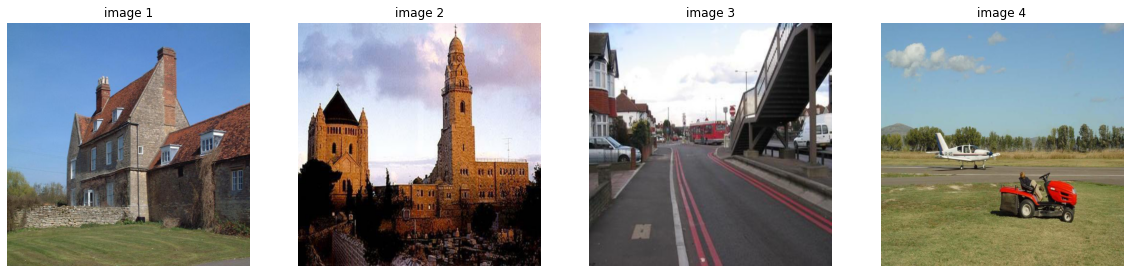

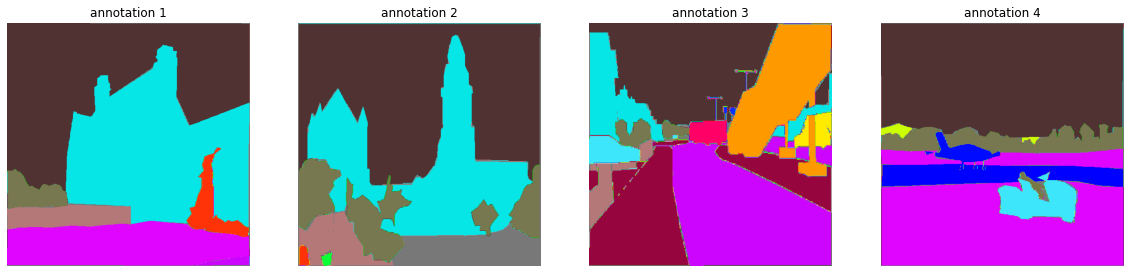

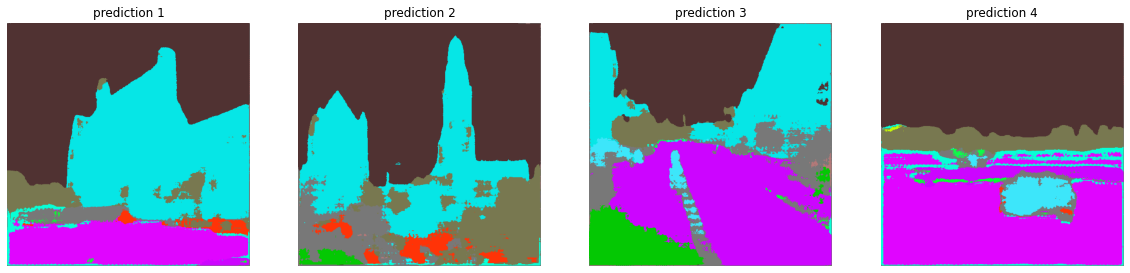

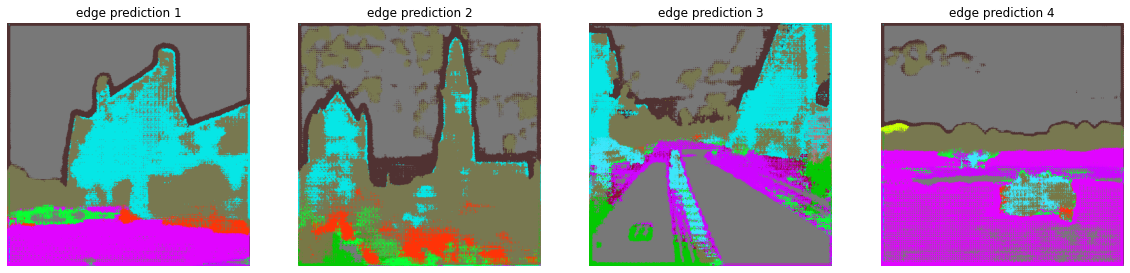

In [45]:
img, mask, edge = next(iter(validation_data_loader))

visualize_prediction_edge_n(img, mask, 4, net)

## Evaluate Model Performance

In [ ]:
validation_data = DataLoaderSegmentationEdge(folder_path, split = "validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 2)
print("Check how many steps in one training epoch: ", len(validation_data_loader))

In [21]:
def intersectionAndUnion(imPred, imLab, numClass):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()

    imPred += 1
    imLab += 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab > 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    return (area_intersection, area_union)

In [18]:
def accuracy(preds, label):
    valid = (label >= 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (valid_sum + 1e-10)
    return acc, valid_sum

In [19]:
def evaluate(segmentation_module, loader):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    intersection_meter_50 = AverageMeter()
    union_meter_50 = AverageMeter()


    segmentation_module.eval()

    for img, seg, edge in tqdm(validation_data_loader):
        # get the prediction here
        pred, edge = segmentation_module(img.to(device))
        pred = pred.detach().cpu()
        pred = np.argmax(pred, axis = 1)

        # calculate accuracy
        acc, pix = accuracy(pred, seg)
        intersection, union = intersectionAndUnion(pred, seg, 151)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)
        intersection_meter_50.update(intersection[0:50])
        union_meter_50.update(union[0:50])


    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    iou_50 = intersection_meter_50.sum / (union_meter_50.sum + 1e-10)
    f= open("/content/iou_baseline.txt","w+")
    for i, _iou in enumerate(iou):
      print('class [{}], IoU: {:.4f}'.format(i, _iou))
      f.write('{}, {:.4f}'.format(i, _iou))
      f.write('\n')

    print('[Eval Summary]:')
    print('Mean IoU: {:.4f}, Mean IoU first 50 classes: {:.4f}, Accuracy: {:.4f}%'
          .format(iou.mean(), iou_50.mean(), acc_meter.average()*100))


In [22]:
evaluate(net, validation_data_loader)

  0%|          | 0/63 [00:00<?, ?it/s]

class [0], IoU: 0.1545
class [1], IoU: 0.5040
class [2], IoU: 0.4776
class [3], IoU: 0.8275
class [4], IoU: 0.5477
class [5], IoU: 0.4897
class [6], IoU: 0.5908
class [7], IoU: 0.4847
class [8], IoU: 0.5978
class [9], IoU: 0.3615
class [10], IoU: 0.4315
class [11], IoU: 0.1890
class [12], IoU: 0.0000
class [13], IoU: 0.3136
class [14], IoU: 0.0483
class [15], IoU: 0.0608
class [16], IoU: 0.1901
class [17], IoU: 0.0444
class [18], IoU: 0.2891
class [19], IoU: 0.3928
class [20], IoU: 0.2409
class [21], IoU: 0.1843
class [22], IoU: 0.1154
class [23], IoU: 0.4071
class [24], IoU: 0.0718
class [25], IoU: 0.0002
class [26], IoU: 0.0000
class [27], IoU: 0.2182
class [28], IoU: 0.0197
class [29], IoU: 0.0000
class [30], IoU: 0.0945
class [31], IoU: 0.0603
class [32], IoU: 0.0067
class [33], IoU: 0.0062
class [34], IoU: 0.0001
class [35], IoU: 0.0256
class [36], IoU: 0.0633
class [37], IoU: 0.3131
class [38], IoU: 0.1352
class [39], IoU: 0.0000
class [40], IoU: 0.0540
class [41], IoU: 0.0000
cl

In [26]:
def multi_acc(pred, label):
    pred = np.argmax(pred, axis = 1)
    corrects = (pred == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [27]:
def evaluate_model(model, val_loader, eval_func):
  model.eval()
  step = len(val_loader)
  acc = []
  with torch.no_grad():
    for img, seg, mask in tqdm(val_loader):
      img = img.to(device)
      prediction_raw, edge_raw = model(img)
      acc.append(eval_func(prediction_raw.cpu(), seg))
  return np.mean(acc)

In [43]:
evaluate_model(net, validation_data_loader, multi_acc)

  0%|          | 0/32 [00:00<?, ?it/s]

56.66526